In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import datetime as dt
from catboost import CatBoostRegressor

In [5]:
# DATA CLEANING 
# dataset = pd.read_csv('/raid/cs152/eBay/eBay_ML_Challenge_Dataset_2021_train.csv')
dataset = pd.read_csv('/raid/cs152/eBay/eBay_ML_Challenge_Dataset_2021_train.csv', nrows=20000)

b2c_c2c = np.array(dataset["b2c_c2c"])
seller_id = np.array(dataset["seller_id"])
declared_handling_days = np.array(dataset["declared_handling_days"])
acceptance_scan_timestamp = np.array(dataset["acceptance_scan_timestamp"])
shipment_method_id = np.array(dataset["shipment_method_id"])
shipping_fee = np.array(dataset["shipping_fee"])
carrier_min_estimate = np.array(dataset["carrier_min_estimate"])
carrier_max_estimate = np.array(dataset["carrier_max_estimate"])
item_zip = dataset["item_zip"]
buyer_zip = dataset["buyer_zip"]
category_id = np.array(dataset["category_id"])
item_price = np.array(dataset["item_price"])
quantity = np.array(dataset["quantity"])
payment_datetime = np.array(dataset["payment_datetime"])
delivery_date = np.array(dataset["delivery_date"])
weight = np.array(dataset["weight"])
weight_units = np.array(dataset["weight_units"])
package_size = np.array(dataset["package_size"])

def b2c_c2c_to_binary(arr):
    if arr[0] in [0,1]:
        print("Array has already been converted to numeric binary!")
    else:
        for i in range(arr.shape[0]):
            if arr[i][0] == "B":
                arr[i] = 0
            else:
                arr[i] = 1
            
b2c_c2c_to_binary(b2c_c2c)
b2c_c2c = np.array(b2c_c2c, dtype=int)

def round_datetime_to_date(datetime):
    days = datetime.days
    hours = datetime.seconds // 3600
    if hours > 12:
        return days + 1
    else:
        return days

def calculate_handling_and_delivery_days(acceptance_timestamps, payment_timestamps, delivery_date):
    handling_labels = []
    shipping_labels = []
    delivery_labels = []
    for i in range(acceptance_timestamps.shape[0]):
        raw_payment = payment_timestamps[i]
        raw_acceptance = acceptance_timestamps[i]
        #parse raw_payment time string to separate year, month, date, and time
        p_year, p_month, p_date = int(raw_payment[0:4]), int(raw_payment[5:7]), int(raw_payment[8:10])
        p_hour, p_min, p_sec = int(raw_payment[11:13]), int(raw_payment[14:16]), int(raw_payment[17:19])
        p_datetime = dt.datetime(year=p_year, month=p_month, day=p_date, hour=p_hour, minute=p_min, second=p_sec)
            
        #parse raw_acceptance time string to separate year, month, date, and time
        raw_acceptance = acceptance_timestamps[i]
        a_year, a_month, a_date = int(raw_acceptance[0:4]), int(raw_acceptance[5:7]), int(raw_acceptance[8:10])
        a_hour, a_min, a_sec = int(raw_acceptance[11:13]), int(raw_acceptance[14:16]), int(raw_acceptance[17:19])
        a_datetime = dt.datetime(year=a_year, month=a_month, day=a_date, hour=a_hour, minute=a_min, second=a_sec)
        
        raw_delivery = delivery_date[i]
        d_year, d_month, d_date = int(raw_delivery[0:4]), int(raw_delivery[5:7]), int(raw_delivery[8:10])
        d_date = dt.datetime(year=d_year, month=d_month, day=d_date, hour=17)
        
        #handling days = acceptance time - payment time; shipping days = delivery date - acceptance time
        handling_days = a_datetime - p_datetime
        shipping_days = d_date - a_datetime
        delivery_days = d_date - p_datetime
        
        #round to nearest day
        rounded_handling_days = round_datetime_to_date(handling_days)
        rounded_shipping_days = round_datetime_to_date(shipping_days)
        rounded_delivery_days = round_datetime_to_date(delivery_days)
        
        handling_labels.append(rounded_handling_days)
        shipping_labels.append(rounded_shipping_days)
        delivery_labels.append(rounded_delivery_days)
        
    return np.array(handling_labels), np.array(shipping_labels), np.array(delivery_labels)

handling_days, shipping_days, delivery_days = calculate_handling_and_delivery_days(acceptance_scan_timestamp, payment_datetime, delivery_date) 

def convert_weights():
    for i, unit in enumerate(weight_units):
        if unit == 2:
            #convert weight to lbs; 1 kg = 2.20462 lbs.
            weight[i] *= 2.20462

convert_weights()

def determine_weight_averages_by_category_id():
    category_id_weights = {}
    for i, w in enumerate(weight):
        category = category_id[i]
        if category not in category_id_weights:
            category_id_weights[category] = [w]
        else:
            category_id_weights[category].append(w)
    
    category_id_weight_means = {}
    for category in category_id_weights:
        weights = category_id_weights[category]
        average_weight = np.mean(weights)
        category_id_weight_means[category] = average_weight
    
    return category_id_weight_means

def fill_missing_weights():
    weight_means = determine_weight_averages_by_category_id()
    overall_mean = np.mean(weight)
    for i, w in enumerate(weight):
        if w == 0:
            #weight is missing, replace with average weight across same category id
            category = category_id[i]
            if category in weight_means:
                weight[i] = weight_means[category]
            else:
                #don't have records for this category id, so replace with overall average
                weight[i] = overall_mean

fill_missing_weights()

def string_to_numeric_package_size():
    if type(package_size[0]) == int:
        print("Already converted to discrete numeric values")
    else:
        encodings = {"LETTER": 0, "PACKAGE_THICK_ENVELOPE": 1, "LARGE_ENVELOPE": 2,"VERY_LARGE_PACKAGE": 3, 
                     "LARGE_PACKAGE": 4, "EXTRA_LARGE_PACKAGE": 5, "NONE": -1}
        for i, size in enumerate(package_size):
            package_size[i] = encodings[size]
string_to_numeric_package_size()

def determine_average_weight_by_package_size():
    package_size_weights = {}
    for i, w in enumerate(weight):
        p_size = package_size[i]
        if p_size not in package_size_weights:
            package_size_weights[p_size] = [w]
        else:
            package_size_weights[p_size].append(w)
    
    package_id_weight_means = {}
    for p_size in package_size_weights:
        weights = package_size_weights[p_size]
        average_weight = np.mean(weights)
        package_id_weight_means[p_size] = average_weight
    
    return package_id_weight_means

def fill_missing_package_sizes():
    weight_means = determine_average_weight_by_package_size()
    weight_means.pop(-1, None)
    weight_means_list = [weight_means[key] for key in weight_means]
    for i, s in enumerate(package_size):
        if s == -1:
            #package size is missing, replace with package size it's weight is closest to the average of
            w = weight[i]
            abs_function = lambda value: abs(value-w)
            closest_value = min(weight_means_list, key=abs_function)
            closest_p_size = weight_means_list.index(closest_value)
            package_size[i] = closest_p_size

fill_missing_package_sizes()

def determine_average_shipping_estimates_by_shipment_method():    
    carrier_min_by_shipment_method = {}
    carrier_max_by_shipment_method = {}
    for i, method_id in enumerate(shipment_method_id):
        carrier_min = carrier_min_estimate[i]
        carrier_max = carrier_max_estimate[i]
        if method_id not in carrier_min_by_shipment_method:
            carrier_min_by_shipment_method[method_id] = [carrier_min]
        else:
            carrier_min_by_shipment_method[method_id].append(carrier_min)

        if method_id not in carrier_max_by_shipment_method:
            carrier_max_by_shipment_method[method_id] = [carrier_max]
        else:
            carrier_max_by_shipment_method[method_id].append(carrier_max)
    
    carrier_min_means = {}
    for method_id in carrier_min_by_shipment_method:
        min_estimates = carrier_min_by_shipment_method[method_id]
        mean_min_estimate = np.mean(min_estimates)
        carrier_min_means[method_id] = mean_min_estimate
    
    carrier_max_means = {}
    for method_id in carrier_max_by_shipment_method:
        max_estimates = carrier_max_by_shipment_method[method_id]
        mean_max_estimate = np.mean(max_estimates)
        carrier_max_means[method_id] = mean_max_estimate 
    
    return carrier_min_means, carrier_max_means

def fill_missing_carrier_estimates():
    #consider replacing missing values with estimates with similar distance
    carrier_min_means, carrier_max_means = determine_average_shipping_estimates_by_shipment_method()
    overall_min_mean, overall_max_mean = np.mean(carrier_min_estimate), np.mean(carrier_max_estimate)
    for i, estimate in enumerate(carrier_min_estimate):
        if estimate < 0:
            #need to fill value 
            method_id = shipment_method_id[i]
            if method_id in carrier_min_means:
                carrier_min_estimate[i] = carrier_min_means[method_id]
            else:
                carrier_min_estimate[i] = overall_min_mean
    for i, estimate in enumerate(carrier_max_estimate):
        if estimate < 0:
            #need to fill value
            method_id = shipment_method_id[i]
            if method_id in carrier_max_means:
                carrier_max_estimate[i] = carrier_max_means[method_id]
            else:
                carrier_max_estimate[i] = overall_max_mean

fill_missing_carrier_estimates()

def fill_missing_declared_handling_days():
    overall_mean = np.mean(declared_handling_days)
    seller_counts = Counter(seller_id)
    for i, days in enumerate(declared_handling_days):
        if np.isnan(days):
            #need to fill
            declared_handling_days[i] = overall_mean

# Turning these zipcodes into strings because they're categorical data 
# and to account for the "-" character in some zipcodes
def check_zipcodes():
    for i, zipcode in enumerate(item_zip):
        item_zip[i] = str(zipcode)
    for i, zipcode in enumerate(buyer_zip):
        item_zip[i] = str(zipcode)

check_zipcodes()
            
features = np.column_stack((b2c_c2c, seller_id, declared_handling_days, shipment_method_id, shipping_fee,
                             carrier_min_estimate, carrier_max_estimate, item_zip, buyer_zip, category_id,
                             item_price, weight, quantity, package_size, handling_days))
labels = np.array(delivery_days)


/tmp/ipykernel_504755/1249350296.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_zip[i] = str(zipcode)
/tmp/ipykernel_504755/1249350296.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_zip[i] = str(zipcode)


In [6]:
X = features
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)

CAT_FEATURES are the catagorical features. early_stopping_rounds tells the model to stop if it doesn't
improve for 10 rounds (stopping overfitting). 

In [7]:
CAT_FEATURES = [0, 3, 7, 8, 9, 13] # b2c_c2c, shipment_method_id, item_zip, buyer_zip, category_id, package_size

model = CatBoostRegressor(iterations=100,
                                   cat_features = CAT_FEATURES,
                                   early_stopping_rounds=10)
# train model
model.fit(X_train, y_train, 
                   eval_set = (X_test, y_test),
                   plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.317353
0:	learn: 2.6177683	test: 2.5458622	best: 2.5458622 (0)	total: 60.7ms	remaining: 6.01s
1:	learn: 2.2570835	test: 2.2173261	best: 2.2173261 (1)	total: 69.2ms	remaining: 3.39s
2:	learn: 2.0666028	test: 2.0402620	best: 2.0402620 (2)	total: 73.3ms	remaining: 2.37s
3:	learn: 1.9245124	test: 1.9056331	best: 1.9056331 (3)	total: 76.2ms	remaining: 1.83s
4:	learn: 1.8322764	test: 1.8157585	best: 1.8157585 (4)	total: 81.8ms	remaining: 1.55s
5:	learn: 1.7582891	test: 1.7424428	best: 1.7424428 (5)	total: 89.6ms	remaining: 1.4s
6:	learn: 1.7092958	test: 1.6955389	best: 1.6955389 (6)	total: 93.4ms	remaining: 1.24s
7:	learn: 1.6772955	test: 1.6653110	best: 1.6653110 (7)	total: 97ms	remaining: 1.11s
8:	learn: 1.6566670	test: 1.6475550	best: 1.6475550 (8)	total: 101ms	remaining: 1.02s
9:	learn: 1.6477816	test: 1.6438439	best: 1.6438439 (9)	total: 105ms	remaining: 945ms
10:	learn: 1.6330187	test: 1.6356624	best: 1.6356624 (10)	total: 108ms	remaining: 876ms
11:	learn: 1.6202

In [8]:
def evaluate_loss(preds, actual):
    early_loss, late_loss = 0,0 
    for i in range(len(preds)):
        if preds[i] < actual[i]:
            #early shipment
            early_loss += actual[i] - preds[i]
        elif preds[i] > actual[i]:
            #late shipment
            late_loss += preds[i] - actual[i]
    loss = (1/len(preds)) * (0.4 * (early_loss) + 0.6 * (late_loss))
    return loss

Below is evaluation of the model using the loss function from eBay


In [9]:
train_score = model.score(X_train, y_train)
print("train score: " + str(train_score))
pred = model.predict(X_test)
loss = evaluate_loss(pred, y_test)
print("loss: " + str(loss))

train score: 0.7757475557307081
loss: 0.49784642341600205


In [10]:
# Following is fine tuning of the model. I tried using the same structure as Millie's fine tuning 
# with xgboost but can't seem to get it working yet. 

from sklearn.model_selection import RandomizedSearchCV
print("Tuning")

params = {
    # Parameters that we are going to tune.
    'depth':[int(x) for x in np.linspace(start=1, stop=20, num=1)],
    'l2_leaf_reg':[0,1,2,3,4,5,6,7,8,9,10],
    'learning_rate':[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005],
    'bagging_temperature': [x/100 for x in np.linspace(start=0, stop=100, num=1)],
    'random_strength': [x/100 for x in np.linspace(start=0, stop=100, num=1)],
}

cat_random_search = RandomizedSearchCV(estimator=model,
                                      param_distributions = params,
                                      n_iter = 100,
                                      cv=3,
                                      verbose=2,
                                      random_state=47,
                                      n_jobs=2)

cat_random_search.fit(X_train, y_train)
print(cat_random_search.best_params_)

Tuning
Fitting 3 folds for each of 88 candidates, totalling 264 fits


/opt/mambaforge/envs/cs152/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 88 is smaller than n_iter=100. Running 88 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 2.6379166	total: 51.8ms	remaining: 5.12s
1:	learn: 2.3787115	total: 56.7ms	remaining: 2.78s
2:	learn: 2.1920931	total: 60.7ms	remaining: 1.96s
3:	learn: 2.0641511	total: 62ms	remaining: 1.49s
4:	learn: 1.9469777	total: 63.3ms	remaining: 1.2s
5:	learn: 1.8813251	total: 64.6ms	remaining: 1.01s
6:	learn: 1.8438984	total: 65.8ms	remaining: 875ms
7:	learn: 1.8022386	total: 67.1ms	remaining: 772ms
8:	learn: 1.7724408	total: 68.3ms	remaining: 691ms
9:	learn: 1.7507563	total: 69.7ms	remaining: 627ms
10:	learn: 1.7339556	total: 70.9ms	remaining: 574ms
11:	learn: 1.7196614	total: 72ms	remaining: 528ms
12:	learn: 1.7079347	total: 73.2ms	remaining: 490ms
13:	learn: 1.6985732	total: 74.3ms	remaining: 456ms
14:	learn: 1.6935785	total: 75.5ms	remaining: 428ms
15:	learn: 1.6896904	total: 77ms	remaining: 404ms
16:	learn: 1.6866396	total: 78.3ms	remaining: 382ms
17:	learn: 1.6828104	total: 79.5ms	remaining: 362ms
18:	learn: 1.6800938	total: 80.8ms	remaining: 344ms
19:	learn: 1.6776511	total: 8

Below are the tuned paratemeters. Several of them are zero, making me think that something is wrong
with the tuning above. Need to fix.

In [11]:
best_params = cat_random_search.best_params_
depth = best_params["depth"]
l2_leaf_reg = best_params["l2_leaf_reg"]
learning_rate = best_params["learning_rate"]
bagging_temperature = best_params["bagging_temperature"]
random_strength = best_params["random_strength"]
print(depth, l2_leaf_reg, learning_rate, bagging_temperature, random_strength)

1 0 0.2 0.0 0.0


In [12]:
print("After fine tuning")
model2 = CatBoostRegressor(iterations=100,
                           cat_features = CAT_FEATURES,
                           early_stopping_rounds=10,
                           depth=depth,
                           l2_leaf_reg=l2_leaf_reg,
                           learning_rate=learning_rate,
                           bagging_temperature=bagging_temperature,
                           random_strength=random_strength
                          )
# train model
model2.fit(X_train, y_train, 
                   eval_set = (X_test, y_test),
                   plot = True)

After fine tuning


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.9287760	test: 2.8472944	best: 2.8472944 (0)	total: 6.67ms	remaining: 660ms
1:	learn: 2.7759181	test: 2.7881325	best: 2.7881325 (1)	total: 10.9ms	remaining: 534ms
2:	learn: 2.6406242	test: 2.6186284	best: 2.6186284 (2)	total: 14.9ms	remaining: 481ms
3:	learn: 2.5249061	test: 2.4960490	best: 2.4960490 (3)	total: 16.1ms	remaining: 386ms
4:	learn: 2.4209533	test: 2.3515810	best: 2.3515810 (4)	total: 17.3ms	remaining: 329ms
5:	learn: 2.3351271	test: 2.3087019	best: 2.3087019 (5)	total: 18.5ms	remaining: 289ms
6:	learn: 2.2491951	test: 2.2151762	best: 2.2151762 (6)	total: 19.6ms	remaining: 261ms
7:	learn: 2.1832154	test: 2.1267397	best: 2.1267397 (7)	total: 20.9ms	remaining: 240ms
8:	learn: 2.1226675	test: 2.0633001	best: 2.0633001 (8)	total: 22ms	remaining: 222ms
9:	learn: 2.0641953	test: 2.0295832	best: 2.0295832 (9)	total: 23.2ms	remaining: 209ms
10:	learn: 2.0135501	test: 1.9689671	best: 1.9689671 (10)	total: 24.3ms	remaining: 197ms
11:	learn: 1.9752255	test: 1.9534087	best: 

Below, the loss is actually worse than before trying to tune. Sketchy, need to fix. 

In [13]:
train_score = model2.score(X_train, y_train)
print("train score: " + str(train_score))
pred = model2.predict(X_test)
loss = evaluate_loss(pred, y_test)
print("loss: " + str(loss))

train score: 0.7367597884304318
loss: 0.5079032467106589


Below I attempted to extract feature importances. Pretty janky, need to work on more. 

[ 7 12  0  5  8  4  9 13 10  6 11  2  1  3 14]


Text(0.5, 0, 'CatBoost Feature Importance')

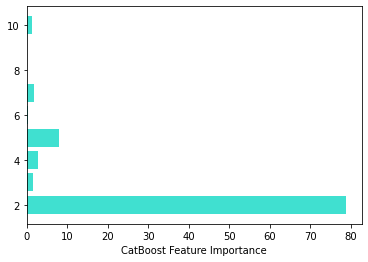

In [14]:
from matplotlib import pyplot as plt

sorted_feature_importance = model.feature_importances_.argsort()
print(sorted_feature_importance)
plt.barh(labels[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print("Testing performance")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 1.54
R2: 0.75


In [16]:
from catboost import Pool

train_pool = Pool(X_train, y_train, cat_features=CAT_FEATURES)
model3 = CatBoostRegressor(n_estimators=100, cat_features=CAT_FEATURES)
model3.fit(train_pool)

prediction_diff = model3.get_feature_importance(train_pool,
                                               type='PredictionDiff',
                                               prettified=True)

model3.plot_predictions(data=train_pool,
                       features_to_change=prediction_diff["Feature Id"][:2],
                       plot=True,
                       plot_file="plot_predictions_file.html")

Learning rate set to 0.408321
0:	learn: 2.4893732	total: 7.29ms	remaining: 722ms
1:	learn: 2.0894035	total: 13.7ms	remaining: 673ms
2:	learn: 1.9050932	total: 19ms	remaining: 613ms
3:	learn: 1.7775246	total: 21.5ms	remaining: 516ms
4:	learn: 1.7207134	total: 24.6ms	remaining: 467ms
5:	learn: 1.6764240	total: 27.4ms	remaining: 430ms
6:	learn: 1.6421725	total: 30.7ms	remaining: 408ms
7:	learn: 1.6332466	total: 32.1ms	remaining: 369ms
8:	learn: 1.6166588	total: 34.9ms	remaining: 353ms
9:	learn: 1.6137687	total: 36.6ms	remaining: 329ms
10:	learn: 1.6056405	total: 39.4ms	remaining: 318ms
11:	learn: 1.6025425	total: 41.4ms	remaining: 304ms
12:	learn: 1.5860670	total: 44.4ms	remaining: 297ms
13:	learn: 1.5811422	total: 46.3ms	remaining: 285ms
14:	learn: 1.5798953	total: 48.1ms	remaining: 273ms
15:	learn: 1.5766750	total: 50.9ms	remaining: 267ms
16:	learn: 1.5658755	total: 53.8ms	remaining: 263ms
17:	learn: 1.5595264	total: 56.7ms	remaining: 258ms
18:	learn: 1.5586385	total: 59.2ms	remaining: 

CatBoostError: EFstrType.PredictionDiff requires a pair of documents, found 15000

32:	learn: 2.9433884	total: 49.5ms	remaining: 101ms
33:	learn: 2.9407179	total: 50.6ms	remaining: 98.2ms
34:	learn: 2.9372302	total: 51.7ms	remaining: 96.1ms
35:	learn: 2.9345839	total: 52.7ms	remaining: 93.8ms
36:	learn: 2.9309556	total: 53.8ms	remaining: 91.6ms
37:	learn: 2.9283318	total: 54.8ms	remaining: 89.4ms
38:	learn: 2.9251513	total: 55.8ms	remaining: 87.3ms
39:	learn: 2.9225529	total: 56.8ms	remaining: 85.3ms
40:	learn: 2.9189839	total: 57.8ms	remaining: 83.2ms
41:	learn: 2.9164077	total: 58.9ms	remaining: 81.3ms
42:	learn: 2.9128733	total: 59.9ms	remaining: 79.4ms
43:	learn: 2.9103192	total: 60.9ms	remaining: 77.5ms
44:	learn: 2.9075212	total: 62ms	remaining: 75.7ms
45:	learn: 2.9040321	total: 63.1ms	remaining: 74.1ms
46:	learn: 2.9015125	total: 64.1ms	remaining: 72.3ms
47:	learn: 2.8982219	total: 65.1ms	remaining: 70.5ms
48:	learn: 2.8962978	total: 66.2ms	remaining: 68.9ms
49:	learn: 2.8928671	total: 67.2ms	remaining: 67.2ms
50:	learn: 2.8909551	total: 68.2ms	remaining: 65.